<a href="https://colab.research.google.com/github/sgmurphy00/TOOLS1/blob/google_collab_environment/ART_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Author: Paul Scheidt, Sean Murphy

This Google Colab Scrip Develops multiple machine learning models as well as
implements a GRAD CAM script to visually access model performance.

A Google Colab Pro subscription is recommended for accessing computational
resourses required to train and evaluate model performance on the entire Deep
Sat 6 data set.

In addition, this script requires the Deep Sat 6 data set and data structure to
be stored on Google Drive. This dataset requires roughly 6 GB of available space.
'''

'\nAuthor: Paul Scheidt, Sean Murphy\n\nThis Google Colab Scrip Develops multiple machine learning models as well as \nimplements a GRAD CAM script to visually access model performance.\n\nA Google Colab Pro subscription is recommended for accessing computational \nresourses required to train and evaluate model performance on the entire Deep\nSat 6 data set. \n\nIn addition, this script requires the Deep Sat 6 data set and data structure to \nbe stored on Google Drive. This dataset requires roughly 6 GB of available space.\n'

Quality of Data and Preprocessing

In [2]:
# Required Python Libraries
from google.colab import drive
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Libraries for CNN
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from PIL import Image
from sklearn.model_selection import train_test_split
# Libraries for Visualizing Deeplearning Models
from IPython import display
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [3]:
# Initializing data, developing train/test splits
# Connecting to Deep Stat Database
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATA_PATH = '/content/drive/My Drive/DEEPSAT6/'
# Initializing training and valiadation Data Paths
train_data_path = DATA_PATH + '/X_train_sat6.csv'
train_label_path = DATA_PATH + 'y_train_sat6.csv'
test_data_path = DATA_PATH + 'X_test_sat6.csv'
test_label_path = DATA_PATH + 'y_test_sat6.csv'

# Storing data into pandas dataframes
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

# Investigating Shape of Pandas DataFrame
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [5]:
# Restructuring Training and Test Images to be 3 layers, RGB
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

Text(0.5, 1.0, '0    0\n1    0\n2    0\n3    0\n4    0\n5    1\nName: 3, dtype: uint8')

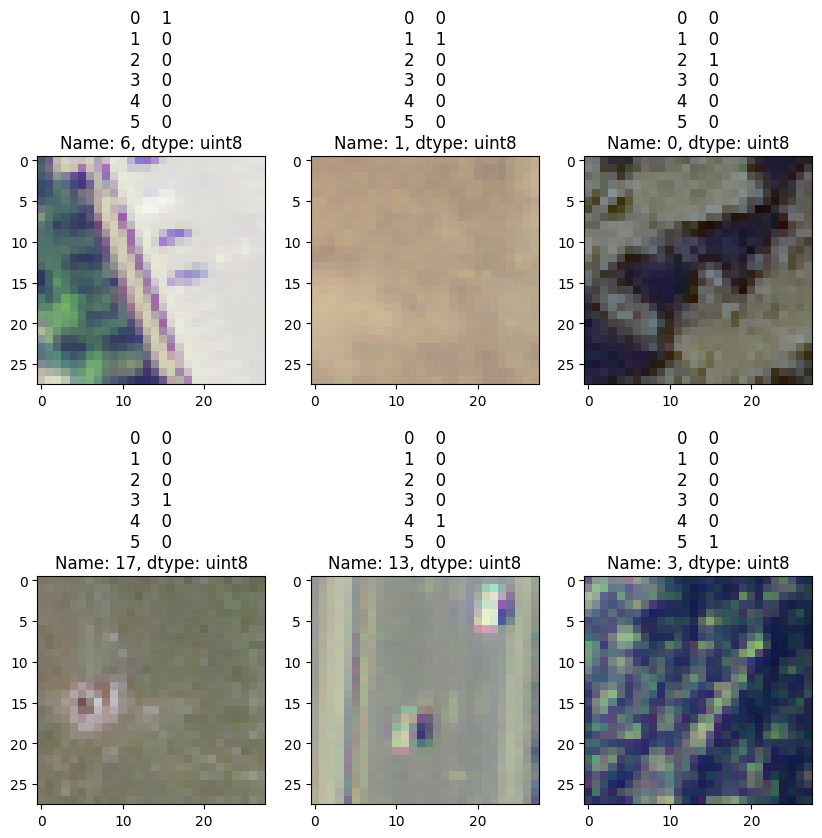

In [6]:
# This Code Block Highlights examples of images from each class
fig = plt.figure(figsize = (10,10))
rows = 2
cols = 3


# plotting Class A
ax1 = fig.add_subplot(rows, cols, 1)
img_A = x_train[6].reshape([28,28,4])[:,:,:3]
label_A = y_train.iloc[6]
plt.imshow(img_A)
ax1.set_title(label_A)

# Plotting Class B
ax2 = fig.add_subplot(rows, cols, 2)
img_B = x_train[1].reshape([28,28,4])[:,:,:3]
label_B = y_train.iloc[1]
plt.imshow(img_B)
ax2.set_title(label_B)

# plotting Class C
ax3 = fig.add_subplot(rows, cols, 3)
img_C = x_train[0].reshape([28,28,4])[:,:,:3]
label_C = y_train.iloc[0]
plt.imshow(img_C)
ax3.set_title(label_C)

# Plotting Class D
ax4 = fig.add_subplot(rows, cols, 4)
img_D = x_train[17].reshape([28,28,4])[:,:,:3]
label_D = y_train.iloc[17]
plt.imshow(img_D)
ax4.set_title(label_D)

# plotting Class E
ax5 = fig.add_subplot(rows, cols,5)
img_E = x_train[13].reshape([28,28,4])[:,:,:3]
label_E = y_train.iloc[13]
plt.imshow(img_E)
ax5.set_title(label_E)

# Plotting Class F
ax6 = fig.add_subplot(rows, cols, 6)
img_F = x_train[3].reshape([28,28,4])[:,:,:3]
label_F = y_train.iloc[3]
plt.imshow(img_F)
ax6.set_title(label_F)

In [9]:
def create_modelv1(class_count, print_summary=False):
# Implementing Multi-Class, Classifier CNN in Tensor Flow
# Description: Implement traditional model, highlight model architecture, train and evaluate model performance

  input = tf.keras.Input(shape=(28,28,4))
  x = layers.Conv2D(filters=32,kernel_size=4,activation='relu')(input)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)
  x= layers.Conv2D(filters=64,kernel_size=4,activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)
  x = layers.GlobalAveragePooling2D()(x)   # Need Global average Pooling in order to visuals CAMs
  x = layers.Dense(128,activation='relu')(x)
  output = layers.Dense(class_count,activation='softmax')(x)

  model = tf.keras.Model(inputs=input,outputs=output)


  model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if print_summary:
    model.summary()
    # Displaying CNN Model
    plt.figure(figsize=(10, 10))
    plot_model(model, show_shapes=True, show_layer_names=True, dpi=100)
  return model

In [10]:

def create_discriminator(class_count, print_summary=False):
  image_size = (28,28)


  input = tf.keras.Input(shape=(28,28,4))
  x = layers.Conv2D(28, 4, strides=(2, 2), padding='same',input_shape=image_size+(1,))(input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(4*2, 4, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = layers.Conv2D(4*4, 4, strides=(2, 2), padding='same', name='final_conv_layer')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128,activation='relu')(x)
  class_output = tf.keras.layers.Dense(class_count,activation='softmax')(x)

  model= keras.Model(input, class_output)

  model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if print_summary:
    model.summary()
    # Displaying CNN Model
    plt.figure(figsize=(10, 10))
    plot_model(model, show_shapes=True, show_layer_names=True, dpi=100)
  return model





In [11]:
# Saving the best model performance for baseline model with early stopping after 5 EPOCHs.
checkpoint = [
    keras.callbacks.ModelCheckpoint(
        filepath="./baseline-model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode='max',
        verbose=1)
]
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
callbacks_list = [checkpoint,earlystop]

In [12]:
# Compiling Modelv1

modelv1 = create_modelv1(6,True)


history_baseline_modelv1 = modelv1.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test,y_test),
    callbacks=callbacks_list)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 25, 25, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,006 (171.90 KB)

 Trainable params: 44,006 (171.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9157 - loss: 0.4215
Epoch 1: val_accuracy improved from -inf to 0.96532, saving model to ./baseline-model.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9157 - loss: 0.4214 - val_accuracy: 0.9653 - val_loss: 0.0966
Epoch 2/10
5057/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9619 - loss: 0.1014
Epoch 2: val_accuracy improved from 0.96532 to 0.96859, saving model to ./baseline-model.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9619 - loss: 0.1014 - val_accuracy: 0.9686 - val_loss: 0.0891
Epoch 3/10
5054/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9682 - loss: 0.0854
Epoch 3: val_accuracy improved from 0.96859 to 0.97486, saving model to ./baseline-model.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9682 - loss: 0.0854 - val_accuracy: 0.9749 - val_loss: 0.0679
Epoch 4/10
5047/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9756 - loss: 0.0684
Epoch 

<Figure size 1000x1000 with 0 Axes>

In [13]:
# Saving the best model performance for Discrimiator model with early stopping after 5 EPOCHs.
checkpoint = [
    keras.callbacks.ModelCheckpoint(
        filepath="./baseline-discrim.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode='max',
        verbose=1)
]
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
callbacks_list = [checkpoint,earlystop]

In [14]:
model_discriminator = create_discriminator(6,True)

history_model_discriminator = model_discriminator.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test,y_test),
    callbacks=callbacks_list)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 28)          │           1,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 28)          │             112 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 8)             │           3,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 8)             │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_conv_layer (Conv2D)            │ (None, 4, 4, 16)            │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,634 (41.54 KB)

 Trainable params: 10,530 (41.13 KB)

 Non-trainable params: 104 (416.00 B)

Epoch 1/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9430 - loss: 0.1783
Epoch 1: val_accuracy improved from -inf to 0.87194, saving model to ./baseline-discrim.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9430 - loss: 0.1783 - val_accuracy: 0.8719 - val_loss: 0.3610
Epoch 2/10
5062/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9784 - loss: 0.0601
Epoch 2: val_accuracy improved from 0.87194 to 0.87646, saving model to ./baseline-discrim.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9784 - loss: 0.0601 - val_accuracy: 0.8765 - val_loss: 0.4689
Epoch 3/10
5061/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9836 - loss: 0.0474
Epoch 3: val_accuracy improved from 0.87646 to 0.96147, saving model to ./baseline-discrim.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9836 - loss: 0.0474 - val_accuracy: 0.9615 - val_loss: 0.0962
Epoch 4/10
5062/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9854 - loss: 0.0422


<Figure size 1000x1000 with 0 Axes>

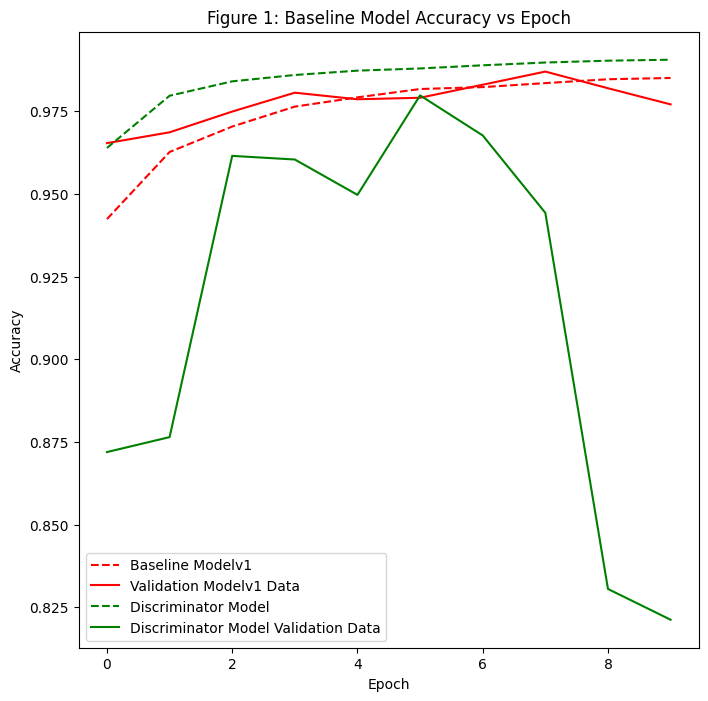

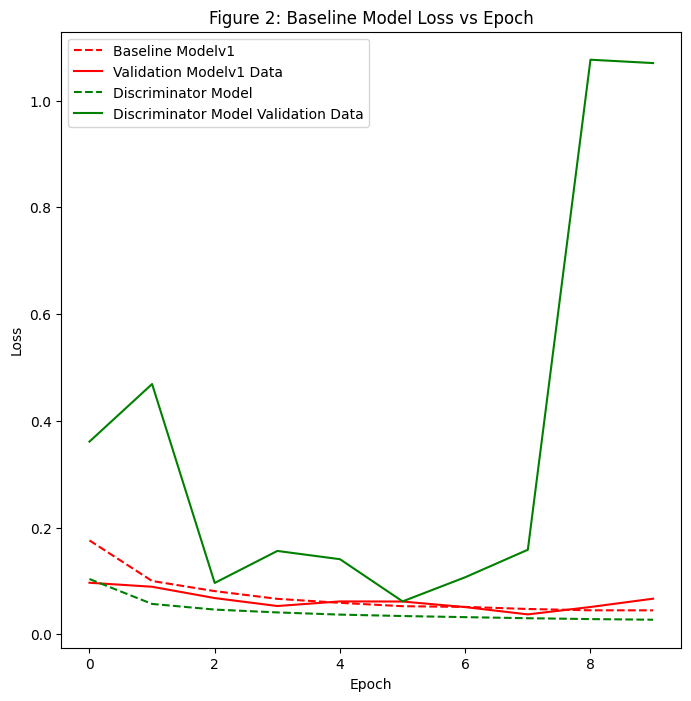

In [15]:
accuracy = plt.figure(figsize =(8, 8))

plt.plot(history_baseline_modelv1.history['accuracy'],'r--',label='Baseline Modelv1')
plt.plot(history_baseline_modelv1.history['val_accuracy'],'r',label='Validation Modelv1 Data')
plt.plot(history_model_discriminator.history['accuracy'],'g--',label='Discriminator Model')
plt.plot(history_model_discriminator.history['val_accuracy'],'g',label='Discriminator Model Validation Data')
plt.title('Figure 1: Baseline Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

loss = plt.figure(figsize =(8, 8))
plt.plot(history_baseline_modelv1.history['loss'],'r--',label='Baseline Modelv1')
plt.plot(history_baseline_modelv1.history['val_loss'],'r',label='Validation Modelv1 Data')
plt.plot(history_model_discriminator.history['loss'],'g--',label='Discriminator Model')
plt.plot(history_model_discriminator.history['val_loss'],'g',label='Discriminator Model Validation Data')
plt.title('Figure 2: Baseline Model Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
# Grad-CAM heatmap Visualization
# Grad-CAM visualizations help verify what areas in an image a model is using to
# determine a class. This visual works by finding the final convolutional layer
# in the network and then investigating the output of the weights prior to global
# pooling.

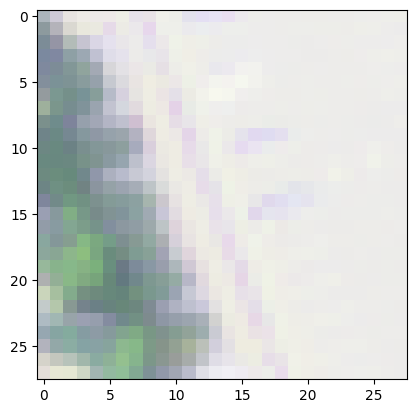

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
[[9.9938071e-01 2.0823933e-10 1.8402396e-08 4.7948390e-10 6.1921449e-04
  2.7474828e-08]]
0


In [17]:
# Extracting a single image from test dataset
image_array = Image.fromarray(x_train[6])
plt.imshow(image_array)
plt.show()

# Loading best models
model_a = load_model('./baseline-model.keras')
model_b = load_model('./baseline-discrim.keras')

# Making a prediction off a single image
pred_a = model_a.predict(x_train[6].reshape([1,28,28,4]))

print(pred_a)

class_a = np.argmax(pred_a)

print(class_a)




In [18]:
# Setting up a model that returns the last convolutional output

conv_layer_name = "final_conv_layer"
conv_output = model_b.get_layer(conv_layer_name).output
pred_output = model_b.get_layer("dense_2").output

CAM_model_b = Model(inputs=model_b.input, outputs=(conv_output, pred_output))

conv, pred = CAM_model_b.predict(x_train[6].reshape([1,28,28,4]))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


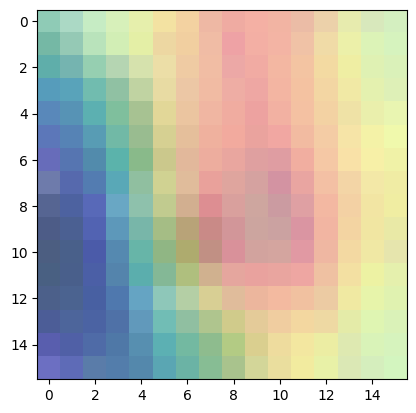

In [19]:
# Reference: https://tree.rocks/get-heatmap-from-cnn-convolution-neural-network-aka-grad-cam-222e08f57a34

from scipy.ndimage import zoom

target = np.argmax(pred, axis=1).squeeze()
w, b = CAM_model_b.get_layer("dense_2").weights
weights = w[:, target].numpy()

heatmap = conv.squeeze().dot(weights)



plt.imshow(image_array)
plt.imshow(zoom(heatmap, zoom=(28/7, 28/7)), cmap='jet', alpha=0.3)

Text(0.5, 1.0, '0    1\n1    0\n2    0\n3    0\n4    0\n5    0\nName: 6, dtype: uint8')

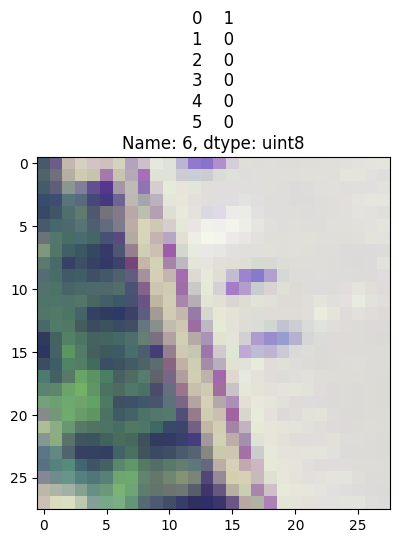

In [20]:

# Comparing Visual Performance

fig = plt.figure(figsize = (10,10))
rows = 1
cols = 2


# plotting Class A
ax1 = fig.add_subplot(rows, cols, 1)
img_A = x_train[6].reshape([28,28,4])[:,:,:3]
label_A = y_train.iloc[6]
plt.imshow(img_A)
ax1.set_title(label_A)